In [1]:
#!pip install freetype-py svgpathtools shapely matplotlib

In [66]:
FONT_NAME = "Arial"
FONT_SIZE = 20            # mm
SCALE = 1.0               # additional scaling

SAFE_Z = 5.0
CUT_Z = -0.5
FEED_RATE = 800           # mm/min


text = "Hello quick brown fox"

In [67]:
import freetype
import numpy as np
from matplotlib import font_manager


def find_font_path(family="Arial", weight="regular"):
    prop = font_manager.FontProperties(
        family=family,
        weight=weight
    )
    font_path = font_manager.findfont(prop, fallback_to_default=False)
    return font_path


FONT_PATH = find_font_path(FONT_NAME)
print(FONT_PATH)

face = freetype.Face(FONT_PATH)
face.set_char_size(int(FONT_SIZE * 64))
#face.set_pixel_sizes(0, int(FONT_SIZE))




C:\Windows\Fonts\arial.ttf


In [81]:
def get_kerning(face, left_char, right_char):
    if not face.has_kerning:
        return 0.0
    return face.get_kerning(
        ord(left_char),
        ord(right_char),
        freetype.FT_KERNING_DEFAULT
    ).x / 64.0

In [82]:
def glyph_to_paths(face, char, x_offset, y_offset):
    face.load_char(char)
    glyph = face.glyph
    outline = glyph.outline

    points = np.array(outline.points, dtype=float)
    if len(points) > 0:
        points /= 64
        points[:, 0] += x_offset
        points[:, 1] += y_offset

    contours = outline.contours
    start = 0
    paths = []

    for end in contours:
        contour = points[start:end + 1]
        contour = np.vstack([contour, contour[0]])
        paths.append(contour)
        start = end + 1

    advance = glyph.advance.x / 64.0
    return paths, advance


In [83]:
all_paths = []

x_cursor = 0.0
y_cursor = face.size.ascender / 64.0   # BASELINE FIX

prev_char = None

for char in text:
    if prev_char:
        x_cursor += get_kerning(face, prev_char, char)

    paths, advance = glyph_to_paths(face, char, x_cursor, y_cursor)
    all_paths.extend(paths)

    x_cursor += advance
    prev_char = char


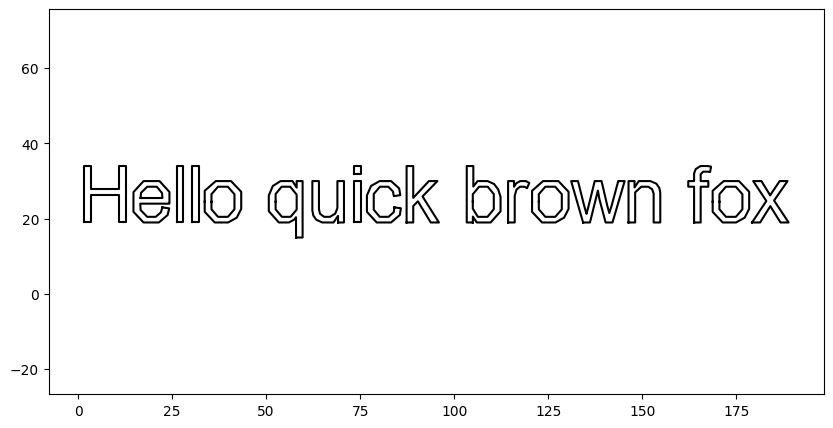

In [84]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))

for contour in all_paths:
    plt.plot(contour[:, 0], contour[:, 1], 'k-')

plt.axis('equal')
#plt.gca().invert_yaxis()
plt.show()


In [24]:
#all_paths

In [ ]:
def contours_to_gcode(contours):
    gcode = []
    gcode.append("G21  ; mm mode")
    gcode.append("G90  ; absolute positioning")

    for contour in contours:
        x0, y0 = contour[0]
        gcode.append(f"G0 Z{SAFE_Z}")
        gcode.append(f"G0 X{x0:.3f} Y{y0:.3f}")
        gcode.append(f"G1 Z{CUT_Z} F{FEED_RATE}")

        for x, y in contour[1:]:
            gcode.append(f"G1 X{x:.3f} Y{y:.3f}")

        gcode.append(f"G0 Z{SAFE_Z}")

    return gcode


In [ ]:
gcode = contours_to_gcode(all_paths)

print("\n".join(gcode[:20]))


In [ ]:
with open("text.nc", "w") as f:
    f.write("\n".join(gcode))


In [14]:
import freetype

face = freetype.Face(FONT_PATH)
face.set_pixel_sizes(0, 40)

for ch in "ABC":
    face.load_char(ch)
    print(ch, face.glyph.advance.x / 64)


A 27.0
B 27.0
C 29.0
